# Machine Learning and Computer Vision
## Assigment 8

---

This assignment contains Tensorflow programming exercises.



## Problem 1: Install Tensorflow 
Follow the directions on https://www.tensorflow.org/install/ to install Tensorflow on your computer.

Note: You will not need GPU support for this assignment so don't worry if you don't have one. Furthermore, installing with GPU support is often more difficult to configure so it is suggested that you install the CPU only version. However, if you have a GPU and would like to install GPU support feel free to do so at your own risk :)

Note: On windows, Tensorflow is only supported in python3, so you will need to install python3 for this assignment.

Run the following cell to verify your instalation.

In [5]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


## Problem 2: Downloading CIFAR10
Download the CIFAR10 dataset (http://www.cs.toronto.edu/~kriz/cifar.html). You will need the python version: http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

Extract the data to ./data
Once extracted run the following cell to view a few example images.

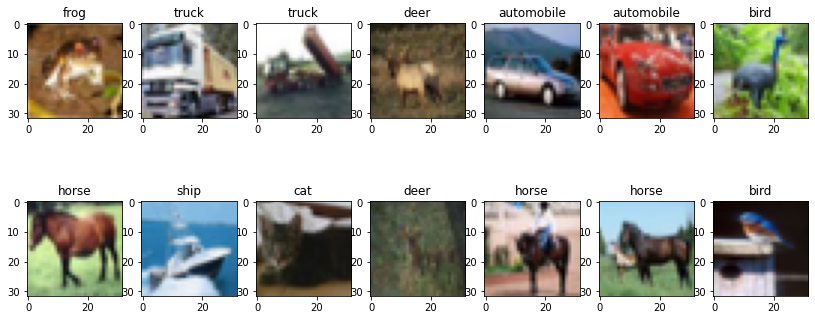

train shape: (50000, 32, 32, 3), (50000,)
test shape : (10000, 32, 32, 3), (10000,)


In [6]:
import numpy as np

# unpickles raw data files
def unpickle(file):
    import pickle
    import sys
    with open(file, 'rb') as fo:
        if sys.version_info[0] < 3:
            dict = pickle.load(fo)
        else:
           dict = pickle.load(fo, encoding='bytes') 
    return dict

# loads data from a single file
def getBatch(file):
    dict = unpickle(file)
    data = dict[b'data'].reshape(-1,3,32,32).transpose(0,2,3,1)
    labels = np.asarray(dict[b'labels'], dtype=np.int64)
    return data,labels

# loads all training and testing data
def getData(path='./data'):
    classes = [s.decode('UTF-8') for s in unpickle(path+'/batches.meta')[b'label_names']]
    
    trainData, trainLabels = [], []
    for i in range(5):
        data, labels = getBatch(path+'/data_batch_%d'%(i+1))
        trainData.append(data)
        trainLabels.append(labels)
    trainData = np.concatenate(trainData)
    trainLabels = np.concatenate(trainLabels)
    
    testData, testLabels = getBatch(path+'/test_batch')
    return classes, trainData, trainLabels, testData, testLabels

# training and testing data that will be used in the following problems
classes, trainData, trainLabels, testData, testLabels = getData()

# display some example images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 6))
for i in range(14):
    plt.subplot(2,7,i+1)
    plt.imshow(trainData[i])
    plt.title(classes[trainLabels[i]])
plt.show()

print ('train shape: ' + str(trainData.shape) + ', ' + str(trainLabels.shape))
print ('test shape : ' + str(testData.shape) + ', ' + str(testLabels.shape))

Below are some helper functions that will be used in the following problems.

In [7]:
# a generator for batches of data
# yields data (batchsize, 3, 32, 32) and labels (batchsize)
# if shuffle, it will load batches in a random order
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize):
        prediction = classifier(data)
        #print (prediction)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print ('Random classifier accuracy: %f'%test(testData, testLabels, randomClassifier))

Random classifier accuracy: 9.910000


## Problem 3: Confusion Matrix
Here you will implement a test script that computes the confussion matrix for a classifier.
The matrix should be nxn where n is the number of classes.
Entry M[i,j] should contain the number of times an image of class i was classified as class j.
M should be normalized such that each row sums to 1.

Hint: see the function test() above for reference.

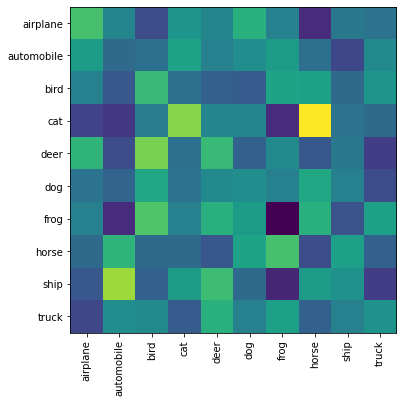

In [8]:
def confusion(testData, testLabels, classifier):
    M = np.zeros((10, 10))
    batchsize=50
    for data,label in DataBatch(testData,testLabels,batchsize):
        prediction = classifier(data)
        for x, y in zip(label, prediction):
            M[x, y] += 1
    M = M/np.sum(M)
    return M


def VisualizeConfussion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)#, vmin=0, vmax=1)
    plt.xticks(np.arange(len(classes)), classes, rotation='vertical')
    plt.yticks(np.arange(len(classes)), classes)
    plt.show()

M = confusion(testData, testLabels, randomClassifier)
VisualizeConfussion(M)

## Problem 4: K-Nearest Neighbors (KNN)
Here you will implement a simple knn classifer. The distance metric is euclidian in pixel space. k refers to the number of neighbors involved in voting on the class.

Hint: you may want to use: sklearn.neighbors.KNeighborsClassifier

In [9]:
from sklearn.neighbors import KNeighborsClassifier
import time
class KNNClassifer():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        self.model = KNeighborsClassifier(k)
        
    def train(self, trainData, trainLabels):
        d = np.reshape(trainData, (trainData.shape[0], trainData.shape[1]*trainData.shape[2]*trainData.shape[3]))
        self.model.fit(d, trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images (batchsize, 32, 32, 3) and return a batch of prediction (batchsize)
        # predictions should be int64 values in the range [0,9] corresponding to the class that the image belongs to
        xx = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
        return self.model.predict(xx)


# test your classifier with only the first 100 training examples (use this while debugging)
# note you should get around 10-20% accuracy
starttime = time.time()
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
endtime = time.time()
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassiferX))
print('time cost: %fs'%(endtime-starttime))

KNN classifier accuracy: 16.600000
time cost: 0.037899s


In [17]:
# test your classifier with all the training examples (This may take a while)
# note you should get around 30% accuracy
knnClassifer = KNNClassifer()
knnClassifer.train(trainData, trainLabels)
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassifer))

# display confusion matrix for your KNN classifier with all the training examples
M = confusion(testData, testLabels, knnClassifer)
VisualizeConfussion(M)

KNN classifier accuracy: 33.030000


KeyboardInterrupt: 

## Problem 5: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN)
Here you will implement a simple knn classifer in PCA space.
You should implement PCA yourself using svd (you may not use sklearn.decomposition.PCA
or any other package that directly implements PCA transofrmations

Hint: Don't forget to apply the same normalization at test time.

Note: you should get similar accuracy to above, but it should run faster.

In [11]:
from sklearn.decomposition import PCA
import numpy as np
import time
class PCAKNNClassifer():
    def __init__(self, components=25, k=3):
        self.components = components
        self.k=k

        
#     def train(self, trainData, trainLabels):
#         d = np.reshape(trainData, (trainData.shape[0], trainData.shape[1]*trainData.shape[2]*trainData.shape[3]))
#         s, u, v = np.linalg.svd(d,full_matrices=0)
#         train = np.dot(d, v.T[:, :self.components])
#         self.model.fit(train, trainLabels)

        
#     def __call__(self, x):
#         xx = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
#         s, u, v = np.linalg.svd(xx,full_matrices=0)
#         xxx = np.dot(xx, v.T[:, :self.components])
#         return self.model.predict(xxx)

    def train(self, trainData, trainLabels):
       
        train = np.reshape(trainData, (trainData.shape[0], trainData.shape[1]*trainData.shape[2]*trainData.shape[3]))
        self.u = np.sum(train,axis = 0)/train.shape[0] #mean
        A = train - self.u
        U, s, Vh =np.linalg.svd(A, full_matrices=False)
        self.v = Vh.T
        A1 = np.dot(A,self.v)
        vec_train = A1[:,0:25]
        self.model = KNeighborsClassifier( self.k, metric= 'euclidean')
        self.model.fit(vec_train, trainLabels)
       
    def __call__(self, x):
        vec_x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
        A2 = np.dot((vec_x - self.u),self.v)
        X_test = A2[:,0:25]
        index = np.zeros([X_test.shape[0], 1])
        index = (self.model.predict(X_test)).astype('int64')
        return index        
    
# test your classifier with only the first 100 training examples (use this while debugging)
starttime = time.time()
pcaknnClassiferX = PCAKNNClassifer()
pcaknnClassiferX.train(trainData[:100], trainLabels[:100])
endtime = time.time()
print ('PCA-KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassiferX))
print('time cost: %fs'%(endtime-starttime))

PCA-KNN classifier accuracy: 16.380000
time cost: 0.101704s


KNN classifier accuracy: 10.000000


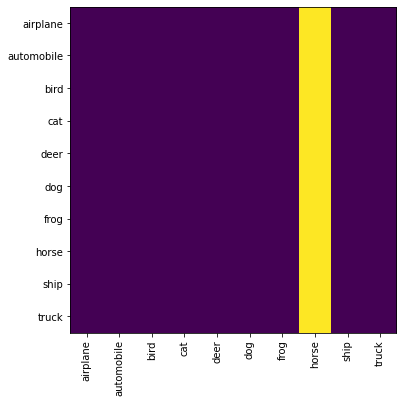

In [12]:
# test your classifier with all the training examples (This may take a few minutes)
pcaknnClassifer = PCAKNNClassifer()
pcaknnClassifer.train(trainData, trainLabels)
print ('KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassifer))

# display the confusion matrix
M = confusion(testData, testLabels, pcaknnClassifer)
VisualizeConfussion(M)

## Deep learning
Below is some helper code to train your deep networks

Hint: see https://www.tensorflow.org/get_started/mnist/pros or https://www.tensorflow.org/get_started/mnist/beginners for reference

200
testing epoch:1 accuracy: 28.300000
200
testing epoch:2 accuracy: 21.880000
200
testing epoch:3 accuracy: 29.580000
200
testing epoch:4 accuracy: 28.080000
200
testing epoch:5 accuracy: 26.810000
200
testing epoch:6 accuracy: 25.110000
200
testing epoch:7 accuracy: 27.330000
200
testing epoch:8 accuracy: 21.490000
200
testing epoch:9 accuracy: 29.140000
200
testing epoch:10 accuracy: 30.910000
200
testing epoch:11 accuracy: 26.600000
200
testing epoch:12 accuracy: 26.140000
200
testing epoch:13 accuracy: 28.040000
200
testing epoch:14 accuracy: 24.520000
200
testing epoch:15 accuracy: 25.630000
200
testing epoch:16 accuracy: 28.970000
200
testing epoch:17 accuracy: 28.130000
200
testing epoch:18 accuracy: 24.020000
200
testing epoch:19 accuracy: 23.020000
200
testing epoch:20 accuracy: 24.990000


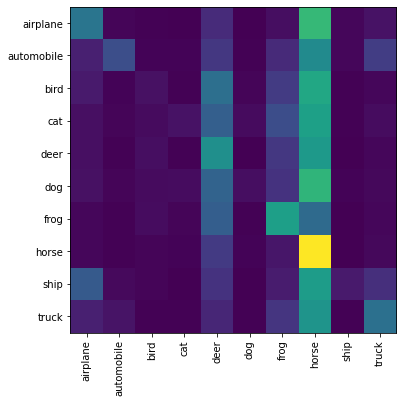

In [19]:
# base class for your Tensorflow networks. It implements the training loop (train) and prediction(__call__)  for you.
# You will need to implement the __init__ function to define the networks structures in the following problems
class TFClassifier():
    def __init__(self):
        pass
    
    def train(self, trainData, trainLabels, epochs=1, batchsize=50):
        self.prediction = tf.argmax(self.y,1)
        self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y_, logits=self.y))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
        self.correct_prediction = tf.equal(self.prediction, self.y_)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for i, (data,label) in enumerate(DataBatch(trainData, trainLabels, batchsize, shuffle=True)):
                _, acc = self.sess.run([self.train_step, self.accuracy], feed_dict={self.x: data, self.y_: label})
                #if i%100==99:
                #    print ('%d/%d %d %f'%(epoch, epochs, i, acc))
                    
            print ('testing epoch:%d accuracy: %f'%(epoch+1, test(testData, testLabels, self)))
        
    def __call__(self, x):
        return self.sess.run(self.prediction, feed_dict={self.x: x})

# helper function to get weight variable
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

# helper function to get bias variable
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# example linear classifier
class LinearClassifer(TFClassifier):
    def __init__(self, classes=10):
        self.sess = tf.Session()

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        # model variables
        self.W = weight_variable([32*32*3,classes])
        self.b = bias_variable([classes])

        # linear operation
        self.y = tf.matmul(tf.reshape(self.x,(-1,32*32*3)),self.W) + self.b
        
# test the example linear classifier (note you should get around 20-30% accuracy)
linearClassifer = LinearClassifer()
linearClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, linearClassifer)
VisualizeConfussion(M)

## Problem 6: Multi Layer Perceptron (MLP)
Here you will implement an MLP. The MLP shoud consist of 3 linear layers (matrix multiplcation and bias offset) that map to the following feature dimensions:

32x32x3 -> hidden

hidden -> hidden

hidden -> classes

The first two linear layers should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output (see: the documentation for tf.nn.sparse_softmax_cross_entropy_with_logits used in the training)

The final output of the computation graph should be stored in self.y as that will be used in the training.

Hint: see the example linear classifier

Note: you should get around 50% accuracy

200
testing epoch:1 accuracy: 39.740000
200
testing epoch:2 accuracy: 42.490000
200
testing epoch:3 accuracy: 44.090000
200
testing epoch:4 accuracy: 42.860000
200
testing epoch:5 accuracy: 47.360000
200
testing epoch:6 accuracy: 46.680000
200
testing epoch:7 accuracy: 46.800000
200
testing epoch:8 accuracy: 48.260000
200
testing epoch:9 accuracy: 48.990000
200
testing epoch:10 accuracy: 47.760000
200
testing epoch:11 accuracy: 49.160000
200
testing epoch:12 accuracy: 48.730000
200
testing epoch:13 accuracy: 50.570000
200
testing epoch:14 accuracy: 49.910000
200
testing epoch:15 accuracy: 50.240000
200
testing epoch:16 accuracy: 49.920000
200
testing epoch:17 accuracy: 49.590000
200
testing epoch:18 accuracy: 50.760000
200
testing epoch:19 accuracy: 49.720000
200
testing epoch:20 accuracy: 51.110000


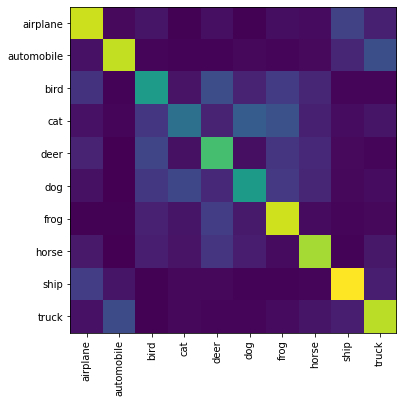

In [86]:
class MLPClassifer(TFClassifier):
    def __init__(self, classes=10, hidden=100):
        self.sess = tf.Session()

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        """your code here"""
        # model variables
        self.n_hidden_1 = 128
        self.n_hidden_2 = 128
        self.weights = [weight_variable([32*32*3,self.n_hidden_1]), weight_variable([self.n_hidden_1, self.n_hidden_2]),weight_variable([self.n_hidden_2, classes])]
#         self.w1 = 
        self.bias = [bias_variable([self.n_hidden_1]), bias_variable([self.n_hidden_2]), bias_variable([classes])]
        

        # operation
        input_layer = tf.reshape(self.x,[-1,32*32*3])
        hidden_layer1 = tf.nn.relu_layer(input_layer, self.weights[0], self.bias[0])
        hidden_layer2 = tf.nn.relu_layer(hidden_layer1, self.weights[1], self.bias[1])
        self.y = tf.matmul(hidden_layer2,self.weights[2]) + self.bias[2]        

        

# test your MLP classifier (note you should get around 50% accuracy)
mlpClassifer = MLPClassifer()
mlpClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, mlpClassifer)
VisualizeConfussion(M)

## Problem 7: Convolutional Neural Network (CNN)
Here you will implement a CNN with the following architecture:

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n) )

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n*2) )

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n*4) )

Linear(output_features=classes)

200
testing epoch:1 accuracy: 42.710000
200
testing epoch:2 accuracy: 48.140000
200
testing epoch:3 accuracy: 50.900000
200
testing epoch:4 accuracy: 53.880000
200
testing epoch:5 accuracy: 55.800000
200
testing epoch:6 accuracy: 56.990000
200
testing epoch:7 accuracy: 58.790000
200
testing epoch:8 accuracy: 59.070000
200
testing epoch:9 accuracy: 60.280000
200
testing epoch:10 accuracy: 60.520000
200
testing epoch:11 accuracy: 61.400000
200
testing epoch:12 accuracy: 61.910000
200
testing epoch:13 accuracy: 61.900000
200
testing epoch:14 accuracy: 62.050000
200
testing epoch:15 accuracy: 63.120000
200
testing epoch:16 accuracy: 62.960000
200
testing epoch:17 accuracy: 63.110000
200
testing epoch:18 accuracy: 62.190000
200
testing epoch:19 accuracy: 62.640000
200
testing epoch:20 accuracy: 62.900000


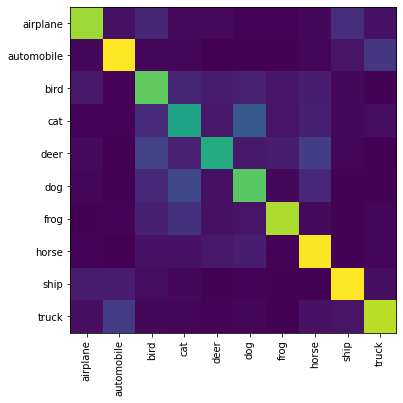

In [25]:
def conv2d(x, W, stride=2):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

class CNNClassifer(TFClassifier):
    def __init__(self, classes=10, n=16):
        self.sess = tf.Session()
        

        
        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels
        # weights
        self.W_conv1 = weight_variable([4,4,3,n])
        self.W_conv2 = weight_variable([4,4,n,2*n])
        self.W_conv3 = weight_variable([4,4,2*n ,4*n])
        self.W_out = weight_variable([4*4*4*n, classes])
        
        # bias
        self.bconv1 = bias_variable([n])
        self.bconv2 = bias_variable([2*n])
        self.bconv3 = bias_variable([4*n])
        self.bconvout = bias_variable([classes])
        
        # stride
        self.stride = 2
      
        # convolution
        self.conv1 = tf.nn.relu(conv2d(self.x,self.W_conv1,self.stride) + self.bconv1)
        self.conv2 = tf.nn.relu(conv2d(self.conv1,self.W_conv2,self.stride) + self.bconv2)
        self.conv3 = tf.nn.relu(conv2d(self.conv2,self.W_conv3,self.stride) + self.bconv3)
        self.y = tf.matmul(tf.reshape(self.conv3, [-1, 4*4*4*n]),self.W_out) + self.bconvout


# test your CNN classifier (note you should get around 65% accuracy)
cnnClassifer = CNNClassifer()
cnnClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, cnnClassifer)
VisualizeConfussion(M)

## Conclusion

Have you accomplished all parts of your assignment? What concepts did you used or learned in this assignment? What difficulties have you encountered? Explain your result for each section. Please wirte one or two short paragraph in the below Markdown window (double click to edit).

**** Your Conclusion: ****

The seven problems in assignment8 can be divided into mainly 3 parts: data loading and basic functions, machine learning, and deep learning. 
For part1(problem1-3), I am required to install tensorflow and download data set and run the given codes. I installed tensorflow2.0 at first but it went wrong for some reason, so I had to reinstall tensorflow. Since assignment8 is written with tf1, I created a virtual environment and installed tf1.15 in it.
For part2(problem4-5), understanding the concepts of KNN and PCA are not difficult, but to implement in the __init__ functions is challenging. For PCA+KNN classifier, it is learned that PCA in sklearn uses svd to realize. The methods run successfully with 100 train and test data, but cost too much time using whole data set. I know it takes a while, but it took nearly 1 hours to train and test and give an accuracy and my computer was super hot.
It is surprising that the time cost of PCA is bigger when applied 100 data in data set but it is smaller when applied the whole data set. 
For part3(problem6-7), neutrual network is totally new to me and it took me some time to understand the basic concepts. Frankly, coding is a really a good way to understand abstract concepts.


## Further reference
To see how state of the art deep networks do on this dataset see: https://github.com/tensorflow/models/tree/master/research/resnet